In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.18.0


### **Download the flowers dataset**
this tutorial uses a dataset of thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

### flowers_photos/
#### daisy/
#### dandelion/
#### roses/
#### sunflowers/
#### tulips/

Note: all images are licensed by CC-BY, creators are listed in the LICENSE.txt file.

Let's load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility.

In [3]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz


--2025-07-30 01:22:54--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   122MB/s    in 1.8s    

2025-07-30 01:22:56 (122 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [4]:
!tar -xvzf flower_photos.tgz


flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [5]:
!tar -xvzf flower_photos.tgz > /dev/null


After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [6]:
from pathlib import Path

data_dir = Path("/content/flower_photos")

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Define some parameters for the loader

**Create a dataset**

In [8]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### *Visualize the data*
Here are the first nine images from the training dataset.

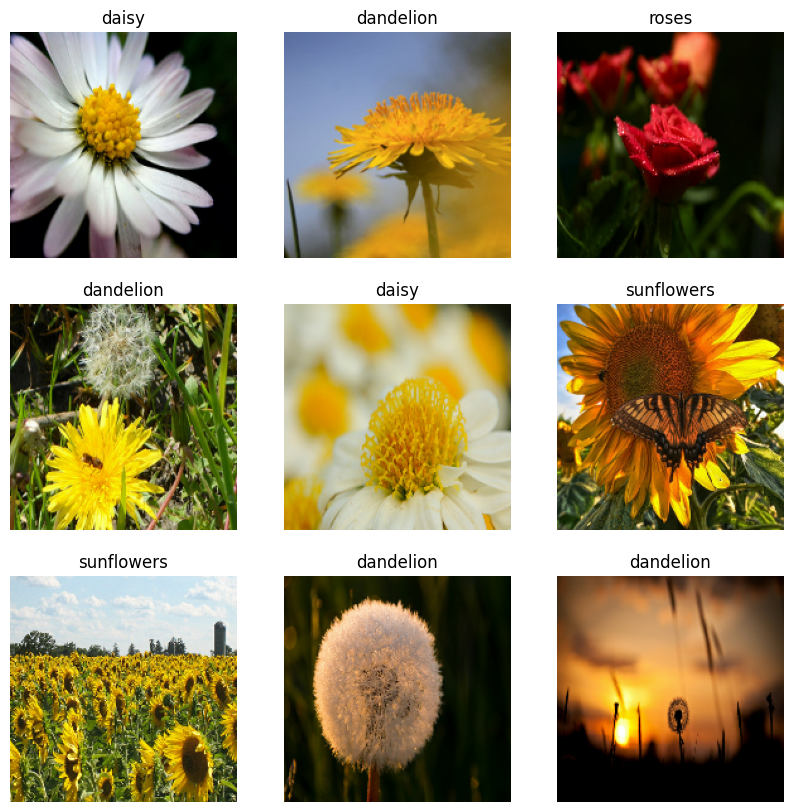

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:


In [15]:
for image_batch, label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180*180*3` (the last dimension refers to color channels RGB). The `labor_batch` is the tensor of the shape `(32,)`, these are corresponding labels to the 32 images, you can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### **Standardize the data**

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

These are two ways to use this layer. You can apply it to the datasetby calling `Dataset.map` :

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### **Configure the dataset for performance**

Let’s make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are the methods you should use when loading data:

- **`Dataset.cache`** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure that the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- **`Dataset.prefetch`** overlaps data preprocessing and model execution while training.


Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Train a model**

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top, activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you how to train a model using the datasets you just created. To learn more about image classification, visit the [Image classification](https://www.tensorflow.org/tutorials/images/classification) tutorial.


In [21]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.


In [22]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [23]:
model.fit(
    train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.3863 - loss: 1.4354 - val_accuracy: 0.5272 - val_loss: 1.1470
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5893 - loss: 1.0361 - val_accuracy: 0.5654 - val_loss: 1.0259
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6703 - loss: 0.8589 - val_accuracy: 0.6104 - val_loss: 0.9634
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7507 - loss: 0.6760 - val_accuracy: 0.5995 - val_loss: 1.1131
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8183 - loss: 0.5051 - val_accuracy: 0.6104 - val_loss: 1.2354
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8611 - loss: 0.3885 - val_accuracy: 0.6035 - val_loss: 1.3919
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8886 - loss: 0.3091 - val_accuracy: 0.6294 - val_loss: 1.3946
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9195 - loss: 0.2129 - val_accuracy: 0.6185 -